# Accelerated DICOM decoding/encoding

This notebook demonstrates how to manipulate DICOM files using nvImageCodec, particularly those that use compressed transfer syntaxes. nvImageCodec can efficiently decode compressed DICOM images, providing significant performance benefits for medical imaging workflows.

## Prerequisites

This notebook requires:
- **pydicom >= 3.0.0**
- **pylibjpeg >= 2.0.0**
- **pylibjpeg-openjpeg >= 2.0.0**

```bash
pip install pydicom>=3.0.0
pip install pylibjpeg>=2.0.0
pip install pylibjpeg-openjpeg>=2.0.0
```

In [1]:
try:
    import pydicom
    from packaging.version import parse
    v = pydicom.__version__
    print(f"pydicom version: {v}")
    if parse(v) < parse("3.0.0"):
        print("⚠️  Please upgrade pydicom to >=3.0.0")
    else:
        print("✓ pydicom version is compatible")
except ImportError:
    print("❌ pydicom is not installed.\nPlease install: pip install pydicom>=3.0.0")


pydicom version: 3.0.1
✓ pydicom version is compatible


Let's run nvidia-smi to verify the GPU available on this system


In [2]:
! nvidia-smi

Mon Nov 10 11:08:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA TITAN V                 Off |   00000000:65:00.0 Off |                  N/A |
| 28%   39C    P8             26W /  250W |      22MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load DICOM Series with pydicom

We will be using DICOM data from the `assets/DICOM/MRI/Knee` directory, which is originally taken from the DALI_extra repository.

Let's load the DICOM series SER00001 and examine its metadata.

In [3]:
import os
import glob
import time

# Path to DICOM series
resources_dir = os.getenv("PYNVIMGCODEC_EXAMPLES_RESOURCES_DIR", "../assets/images")
dicom_series_dir = os.path.join(resources_dir, "DICOM/MRI/Knee/DICOMS/STU00001/SER00001")

# Get all DICOM files in the series
dicom_files = sorted(glob.glob(os.path.join(dicom_series_dir, "*.dcm")))

print(f"Found {len(dicom_files)} DICOM files in series {dicom_series_dir}")
print(f"\nFirst file: {os.path.basename(dicom_files[0])}")
print(f"Last file: {os.path.basename(dicom_files[-1])}")

print(f"Loading {len(dicom_files)} DICOM files...")

start_time = time.time()
dicom_series = [pydicom.dcmread(f) for f in dicom_files]
dcmread_time = time.time() - start_time

# Mention the original transfer syntax from the first DICOM file
original_transfer_syntax = dicom_series[0].file_meta.TransferSyntaxUID.name
print(f"✓ Loaded {len(dicom_series)} files in {dcmread_time:.4f}s ({dcmread_time/len(dicom_files)*1000:.2f} ms/file)")
print(f"Transfer syntax: {original_transfer_syntax}")
print(f"Volume shape: {dicom_series[0].Rows} x {dicom_series[0].Columns} x {len(dicom_series)}")

# Show metadata of the first DICOM file
first_dicom = dicom_series[0]
print("=" * 70)
print("DICOM Metadata")
print("=" * 70)
print(f"Modality: {getattr(first_dicom, 'Modality', 'N/A')}")
print(f"Study: {getattr(first_dicom, 'StudyDescription', 'N/A')}")
print(f"Series: {getattr(first_dicom, 'SeriesDescription', 'N/A')}")
print(f"\nImage Dimensions: {first_dicom.Rows} x {first_dicom.Columns}")
print(f"Bits Stored: {first_dicom.BitsStored} / {first_dicom.BitsAllocated}")
print(f"\nTransfer Syntax: {first_dicom.file_meta.TransferSyntaxUID.name}")
print(f"Is Compressed: {first_dicom.file_meta.TransferSyntaxUID.is_compressed}")

Found 38 DICOM files in series ../assets/images/DICOM/MRI/Knee/DICOMS/STU00001/SER00001

First file: IMG00001.dcm
Last file: IMG00038.dcm
Loading 38 DICOM files...
✓ Loaded 38 files in 0.0419s (1.10 ms/file)
Transfer syntax: Implicit VR Little Endian
Volume shape: 234 x 256 x 38
DICOM Metadata
Modality: MR
Study: JOINTS^KNEE RIGHT
Series: t1_tse_tra

Image Dimensions: 234 x 256
Bits Stored: 12 / 16

Transfer Syntax: Implicit VR Little Endian
Is Compressed: False


Now that we've loaded the DICOM files and their metadata, note that the pixel data itself has not yet been loaded into memory. With pydicom, accessing the `.pixel_array` property will read and decode the pixel data on demand, automatically selecting the correct decoding plugin depending on the file's transfer syntax.

Before decoding the pixel data, we need to ensure the slices are in the correct spatial order. DICOM files may not always be stored in sequential order on disk, so we'll sort them based on their position using metadata fields such as `InstanceNumber`, `ImagePositionPatient`, or `SliceLocation`. This ensures the reconstructed 3D volume has slices in the proper anatomical order.

Sorting slices by slice position...
Sorted by Instance Number

First slice Instance Number: 1
Last slice Instance Number: 38

Decoding pixel data to numpy array...
⏱️  Pixel data decode time: 0.0320 seconds (0.84 ms per slice)

Volume shape: (38, 234, 256)
Volume dtype: uint16
Volume range: [0, 2139]
Memory size: 4.34 MB


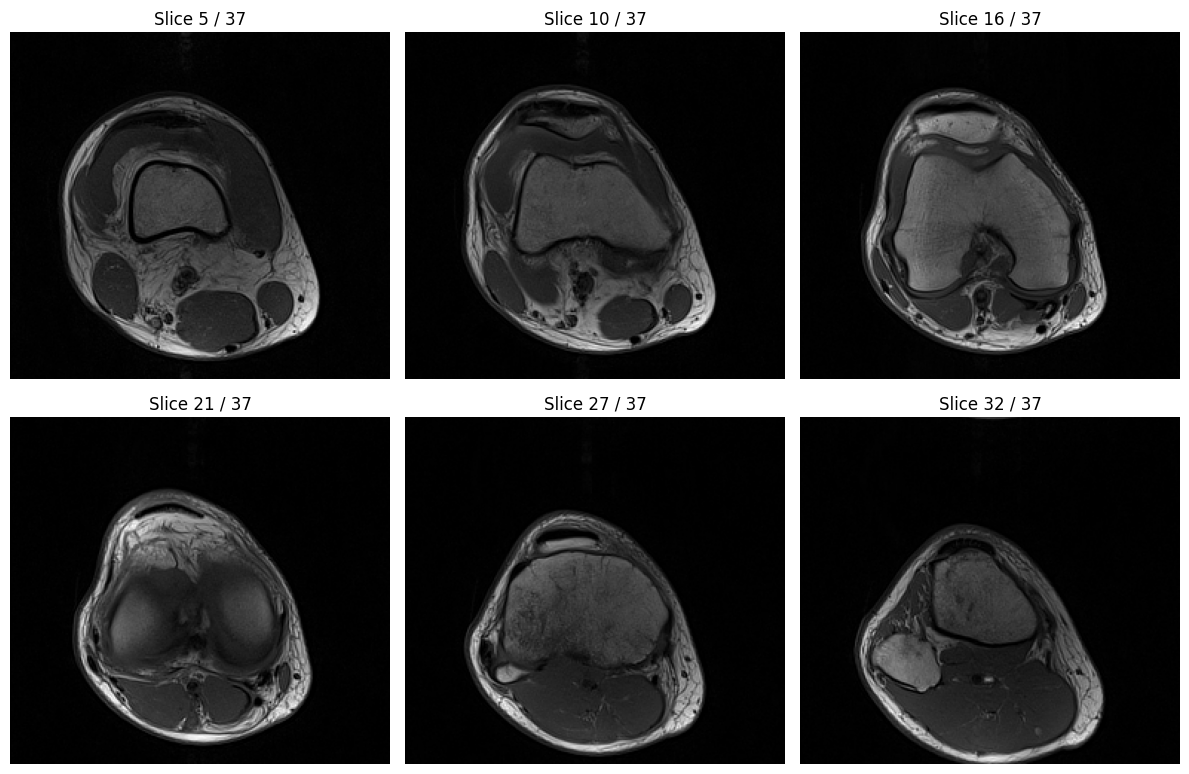

In [4]:
import numpy as np

# Sort slices by Instance Number or Image Position Patient
print("Sorting slices by slice position...")

# Try to sort by Instance Number first (most common)
if hasattr(dicom_series[0], 'InstanceNumber'):
    dicom_series_sorted = sorted(dicom_series, key=lambda x: x.InstanceNumber)
    print("Sorted by Instance Number")
# If Instance Number is not available, sort by Image Position Patient (slice location)
elif hasattr(dicom_series[0], 'ImagePositionPatient'):
    dicom_series_sorted = sorted(dicom_series, key=lambda x: float(x.ImagePositionPatient[2]))
    print("Sorted by Image Position Patient (Z coordinate)")
# Fallback: sort by Slice Location if available
elif hasattr(dicom_series[0], 'SliceLocation'):
    dicom_series_sorted = sorted(dicom_series, key=lambda x: float(x.SliceLocation))
    print("Sorted by Slice Location")
else:
    # Keep original order if no sorting criteria available
    dicom_series_sorted = dicom_series
    print("Warning: No suitable sorting criteria found, keeping original order")

print(f"\nFirst slice Instance Number: {getattr(dicom_series_sorted[0], 'InstanceNumber', 'N/A')}")
print(f"Last slice Instance Number: {getattr(dicom_series_sorted[-1], 'InstanceNumber', 'N/A')}")

# Decode pixel data to numpy array
print("\nDecoding pixel data to numpy array...")

# Time the pixel_array access loop
start_time = time.time()
pixel_arrays = []
for ds in dicom_series_sorted:
    pixel_arrays.append(ds.pixel_array)
volume = np.stack(pixel_arrays)
pixel_decode_time = time.time() - start_time

print(f"⏱️  Pixel data decode time: {pixel_decode_time:.4f} seconds ({pixel_decode_time/len(dicom_series_sorted)*1000:.2f} ms per slice)")
print(f"\nVolume shape: {volume.shape}")
print(f"Volume dtype: {volume.dtype}")
print(f"Volume range: [{volume.min()}, {volume.max()}]")
print(f"Memory size: {volume.nbytes / (1024**2):.2f} MB")


import matplotlib.pyplot as plt

# Visualize a few representative slices from the volume
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Select 6 evenly spaced slices to display
num_slices = volume.shape[0]
slice_indices = [int(i * num_slices / 7) for i in range(1, 7)]

for idx, ax in enumerate(axes):
    slice_idx = slice_indices[idx]
    ax.imshow(volume[slice_idx], cmap="gray")
    ax.set_title(f"Slice {slice_idx} / {num_slices-1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


## Transcode DICOM to HTJ2K with nvImageCodec

The original DICOM files use uncompressed pixel data (Implicit VR Little Endian), which is simple but inefficient for storage and transfer. Let's transcode them to **HTJ2K (High-Throughput JPEG 2000)**, a modern compression standard that offers:

- **Lossless compression**: No quality loss, critical for medical imaging
- **Better compression ratios**: ~2-3x smaller files than uncompressed
- **Hardware-accelerated decoding**: Faster decompression on GPU
- **Standardized**: Official DICOM transfer syntax (UID 1.2.840.10008.1.2.4.201)

HTJ2K is particularly valuable for medical imaging archives, PACS systems, and telemedicine applications where storage costs and network bandwidth are concerns.


In [5]:
from nvidia import nvimgcodec
import tempfile
import shutil
from pydicom.uid import JPEG2000Lossless

# Create encoder instance
encoder = nvimgcodec.Encoder()

# Create temporary directory for HTJ2K transcoded files
htj2k_dir = tempfile.mkdtemp(prefix="dicom_htj2k_")
print(f"Created temporary directory: {htj2k_dir}")

# HTJ2K Transfer Syntax UID
HTJ2K_LOSSLESS_UID = "1.2.840.10008.1.2.4.201"  # High-Throughput JPEG 2000 Image Compression (Lossless Only)

print(f"\nOriginal Transfer Syntax: {dicom_series_sorted[0].file_meta.TransferSyntaxUID.name}")
print(f"Target Transfer Syntax: HTJ2K Lossless")


Created temporary directory: /tmp/dicom_htj2k_cvhp1f7p

Original Transfer Syntax: Implicit VR Little Endian
Target Transfer Syntax: HTJ2K Lossless


In [6]:
# Transcode each DICOM file to HTJ2K
print("\n" + "=" * 70)
print(f"Transcoding {len(dicom_series_sorted)} DICOM files to HTJ2K...")
print("=" * 70)

# Setup encode parameters for HTJ2K lossless
jpeg2k_encode_params = nvimgcodec.Jpeg2kEncodeParams()
jpeg2k_encode_params.num_resolutions = 6  # good balance
jpeg2k_encode_params.code_block_size = (64, 64)
jpeg2k_encode_params.bitstream_type = nvimgcodec.Jpeg2kBitstreamType.J2K
jpeg2k_encode_params.prog_order = nvimgcodec.Jpeg2kProgOrder.LRCP
jpeg2k_encode_params.ht = True  # Enable High Throughput mode

encode_params = nvimgcodec.EncodeParams(
    quality_type=nvimgcodec.QualityType.LOSSLESS,
    jpeg2k_encode_params=jpeg2k_encode_params
)

start_time = time.time()
encoded = [bytes(x) for x in encoder.encode(pixel_arrays, "jpeg2k", params=encode_params)]
total_encode_time = time.time() - start_time

from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.uid import ExplicitVRLittleEndian
from pydicom.encaps import encapsulate

compressed_total_size = 0
original_total_size = 0
htj2k_dicom_files = []

print("Saving HTJ2K-encoded DICOM files...")
for i, ds in enumerate(dicom_series_sorted):
    # Clone the original dataset to preserve all metadata
    new_ds = ds.copy()

    # Update Transfer Syntax UID in file_meta
    new_ds.file_meta.TransferSyntaxUID = HTJ2K_LOSSLESS_UID
    new_ds.file_meta.is_implicit_VR = False
    new_ds.file_meta.is_little_endian = True

    # Encapsulate the HTJ2K encoded data properly for DICOM
    # encapsulate() expects a list of frame fragments
    new_ds.PixelData = encapsulate([encoded[i]])

    # (Optional) update Instance Creation Date/Time for reproducibility
    from datetime import datetime
    new_ds.InstanceCreationDate = datetime.now().strftime('%Y%m%d')
    new_ds.InstanceCreationTime = datetime.now().strftime('%H%M%S.%f')[:18]

    # Save to new directory with the same filename as the original
    original_filename = os.path.basename(ds.filename)
    out_path = os.path.join(htj2k_dir, original_filename)
    new_ds.save_as(out_path)
    htj2k_dicom_files.append(out_path)

    # Check the size of the files on disk (after saving)
    compressed_total_size += os.path.getsize(out_path)
    original_total_size += os.path.getsize(ds.filename)


print("\n========== HTJ2K Encoding Summary ==========")
print(f"• Number of slices encoded     : {len(dicom_series_sorted)}")
print(f"• Total encoding time          : {total_encode_time:.4f} seconds ({total_encode_time/len(dicom_series_sorted)*1000:.2f} ms/slice)")
print("\n📊 Compression Results:")
print(f"  - Original total size        : {original_total_size / 1024:.2f} KB ({original_total_size / (1024**2):.2f} MB)")
print(f"  - Compressed total size      : {compressed_total_size / 1024:.2f} KB ({compressed_total_size / (1024**2):.2f} MB)")
if compressed_total_size > 0:
    print(f"  - Compression ratio          : {original_total_size / compressed_total_size:.2f}x smaller")
    print(f"  - Space saved                : {(original_total_size - compressed_total_size) / 1024:.2f} KB ({(1 - compressed_total_size/original_total_size)*100:.1f}%)")
else:
    print("  - Compression ratio          : N/A (compressed size is zero)")
    print("  - Space saved                : N/A")
print(f"\n✓ All HTJ2K-encoded DICOM files are saved at: {htj2k_dir}")



Transcoding 38 DICOM files to HTJ2K...
Saving HTJ2K-encoded DICOM files...



========== HTJ2K Encoding Summary ==========
• Number of slices encoded     : 38
• Total encoding time          : 0.1175 seconds (3.09 ms/slice)

📊 Compression Results:
  - Original total size        : 4506.39 KB (4.40 MB)
  - Compressed total size      : 1883.03 KB (1.84 MB)
  - Compression ratio          : 2.39x smaller
  - Space saved                : 2623.37 KB (58.2%)

✓ All HTJ2K-encoded DICOM files are saved at: /tmp/dicom_htj2k_cvhp1f7p


## Verify HTJ2K Decoding Performance

Now let's verify the transcoded HTJ2K files can be decoded correctly, and compare decoding performance between pydicom (CPU-based) and nvImageCodec (GPU-accelerated).

⏱️  pydicom decode time:     0.0669s (1.76 ms/file)
⏱️  nvImageCodec decode time: 0.0519s (1.37 ms/file)
🚀 Speedup: 1.29x faster
✓ All decoded slices match original


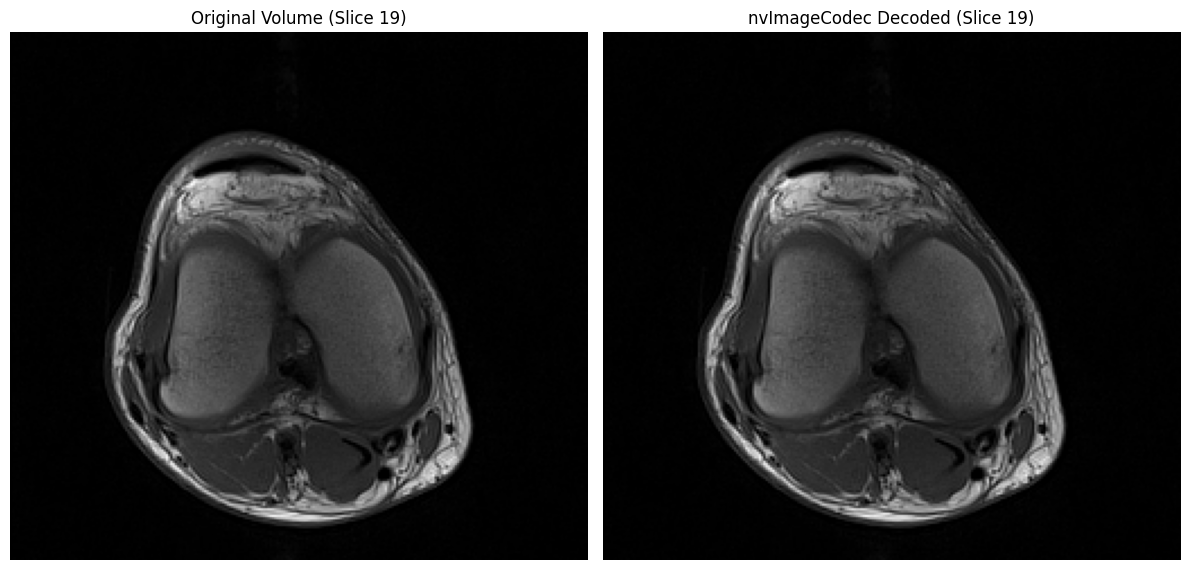

In [7]:
# Parse HTJ2K files
datasets = [pydicom.dcmread(f) for f in htj2k_dicom_files]

# Method 1: pydicom pixel_array (CPU-based decoding)
start_time = time.time()
pydicom_decoded = [ds.pixel_array for ds in datasets]
pydicom_time = time.time() - start_time

# Method 2: nvImageCodec (GPU-accelerated decoding)
decoder = nvimgcodec.Decoder()
decode_params = nvimgcodec.DecodeParams(allow_any_depth=True, color_spec=nvimgcodec.ColorSpec.UNCHANGED)

# Extract encoded frame data from DICOM PixelData
encoded_frames = []
for ds in datasets:
    encoded_frames.extend(pydicom.encaps.generate_frames(ds.PixelData))

start_time = time.time()
nvimg_decoded = decoder.decode(encoded_frames, params=decode_params)
nvimg_time = time.time() - start_time

nvimg_decoded_cpu = [np.array(img.cpu()) for img in nvimg_decoded]

print(f"⏱️  pydicom decode time:     {pydicom_time:.4f}s ({pydicom_time/len(datasets)*1000:.2f} ms/file)")
print(f"⏱️  nvImageCodec decode time: {nvimg_time:.4f}s ({nvimg_time/len(datasets)*1000:.2f} ms/file)")
print(f"🚀 Speedup: {pydicom_time/nvimg_time:.2f}x faster")

# Verify correctness
for idx in range(len(nvimg_decoded_cpu)):
    d = nvimg_decoded_cpu[idx].squeeze()
    assert np.array_equal(d, volume[idx]), f"Slice {idx} mismatch"
print("✓ All decoded slices match original")

# Visual comparison
mid_idx = len(volume) // 2
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(volume[mid_idx], cmap='gray')
axs[0].set_title('Original Volume (Slice {})'.format(mid_idx))
axs[0].axis('off')
axs[1].imshow(nvimg_decoded_cpu[mid_idx], cmap='gray')
axs[1].set_title('nvImageCodec Decoded (Slice {})'.format(mid_idx))
axs[1].axis('off')
plt.tight_layout()
plt.show()

## Multi-Frame DICOM

So far we've been working with single-frame DICOM files (one file per slice). However, DICOM also supports **multi-frame images**, where multiple slices are stored in a single file. This approach offers several advantages:

- **Reduced filesystem overhead**: One file instead of 38 means fewer inodes, faster directory operations
- **Slightly better compression**: Shared metadata reduces redundancy
- **Simplified file management**: Easier to archive, transfer, and track

Let's convert our 38 single-frame HTJ2K files into a single multi-frame HTJ2K DICOM file.

In [8]:
import pydicom.uid
from pydicom.encaps import encapsulate

# Create multi-frame DICOM from single-frame HTJ2K files
output_ds = datasets[0].copy()
output_ds.SOPInstanceUID = output_ds.SeriesInstanceUID

# Collect all encoded frames
all_encoded_frames = []
for ds in datasets:
    frames = list(pydicom.encaps.generate_frames(ds.PixelData))
    all_encoded_frames.extend(frames)

# Encapsulate as multi-frame
output_ds.PixelData = encapsulate(all_encoded_frames, has_bot=True)
output_ds.NumberOfFrames = len(all_encoded_frames)

# Save
multiframe_htj2k_dir = tempfile.mkdtemp(prefix="multiframe_htj2k_")
multi_frame_file = os.path.join(multiframe_htj2k_dir, "multiframe_htj2k.dcm")
output_ds.save_as(multi_frame_file)

print(f"✓ Created multi-frame DICOM: {multi_frame_file}")

# Size comparison
original_size = sum(os.path.getsize(f) for f in dicom_files)
single_htj2k_size = sum(os.path.getsize(f) for f in htj2k_dicom_files)
multi_htj2k_size = os.path.getsize(multi_frame_file)

print(f"\n📦 File Size Comparison:")
print(f"  Original (38 files):      {original_size/1024**2:.2f} MB")
print(f"  Single-frame HTJ2K (38):  {single_htj2k_size/1024**2:.2f} MB ({original_size/single_htj2k_size:.2f}x smaller)")
print(f"  Multi-frame HTJ2K (1):    {multi_htj2k_size/1024**2:.2f} MB ({original_size/multi_htj2k_size:.2f}x smaller)")

✓ Created multi-frame DICOM: /tmp/multiframe_htj2k_ai8u65v3/multiframe_htj2k.dcm

📦 File Size Comparison:
  Original (38 files):      4.40 MB
  Single-frame HTJ2K (38):  1.84 MB (2.39x smaller)
  Multi-frame HTJ2K (1):    1.78 MB (2.47x smaller)


⏱️  pydicom multi-frame decode time: 0.0463s (1.22 ms/frame)
Multi-frame shape: (38, 234, 256)
Transfer Syntax: High-Throughput JPEG 2000 Image Compression (Lossless Only)
✓ All frames match original


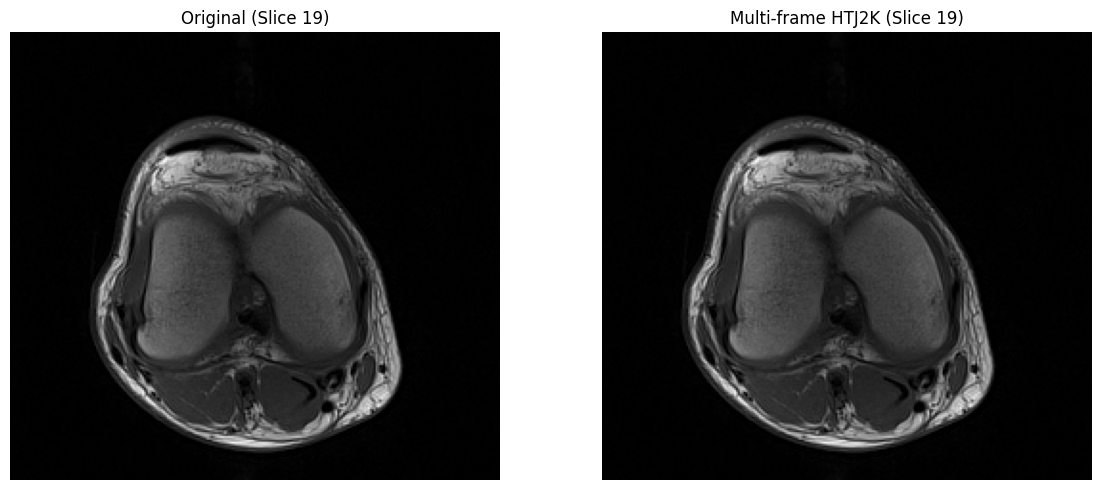

In [9]:
# Verify multi-frame DICOM with pydicom
mf_ds = pydicom.dcmread(multi_frame_file)

start_time = time.time()
mf_arr = mf_ds.pixel_array
pydicom_time = time.time() - start_time

print(f"⏱️  pydicom multi-frame decode time: {pydicom_time:.4f}s ({pydicom_time/len(mf_arr)*1000:.2f} ms/frame)")

print(f"Multi-frame shape: {mf_arr.shape}")
print(f"Transfer Syntax: {mf_ds.file_meta.TransferSyntaxUID.name}")

# Verify all frames match original
orig_stack = np.stack([ds.pixel_array for ds in dicom_series_sorted], axis=0)
assert np.array_equal(orig_stack, mf_arr), "Multi-frame data mismatch!"
print("✓ All frames match original")

# Visual comparison
mid_idx = len(mf_arr) // 2
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(orig_stack[mid_idx], cmap='gray')
axs[0].set_title(f"Original (Slice {mid_idx})")
axs[0].axis('off')
axs[1].imshow(mf_arr[mid_idx], cmap='gray')
axs[1].set_title(f"Multi-frame HTJ2K (Slice {mid_idx})")
axs[1].axis('off')
plt.tight_layout()
plt.show()


Decoding multi-frame HTJ2K with nvImageCodec...
⏱️  Decode time: 0.0119s (0.31 ms/frame)
🚀 Speedup vs pydicom: 3.88x faster with nvImageCodec
✓ nvImageCodec multi-frame decode matches original


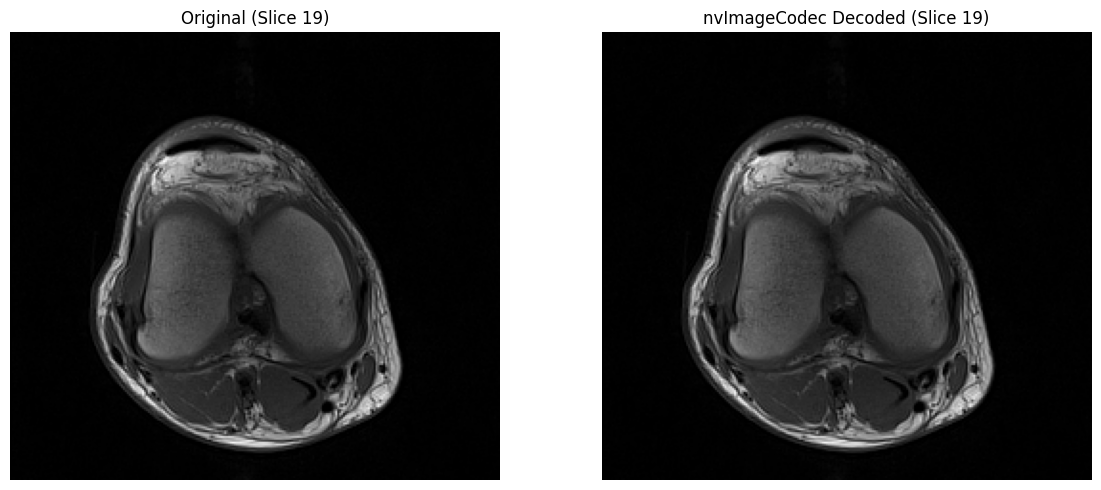

In [10]:
# Decode multi-frame DICOM with nvImageCodec
print("\nDecoding multi-frame HTJ2K with nvImageCodec...")

encoded_frames = list(pydicom.encaps.generate_frames(mf_ds.PixelData))

start_time = time.time()
decoded_frames = decoder.decode(encoded_frames, params=decode_params)
nvimg_time = time.time() - start_time

decoded_arrays = [np.array(x.cpu()).squeeze() for x in decoded_frames]
decoded_stack = np.stack(decoded_arrays, axis=0)

print(f"⏱️  Decode time: {nvimg_time:.4f}s ({nvimg_time/len(decoded_frames)*1000:.2f} ms/frame)")
speedup = pydicom_time / nvimg_time
print(f"🚀 Speedup vs pydicom: {speedup:.2f}x faster with nvImageCodec")


# Verify correctness
assert np.array_equal(decoded_stack, orig_stack), "nvImageCodec decode mismatch!"
print("✓ nvImageCodec multi-frame decode matches original")

# Visual comparison
mid_idx = len(decoded_stack) // 2
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(orig_stack[mid_idx], cmap='gray')
axs[0].set_title(f"Original (Slice {mid_idx})")
axs[0].axis('off')
axs[1].imshow(decoded_stack[mid_idx], cmap='gray')
axs[1].set_title(f"nvImageCodec Decoded (Slice {mid_idx})")
axs[1].axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Cleanup temporary directories
import shutil

shutil.rmtree(htj2k_dir, ignore_errors=True)
shutil.rmtree(multiframe_htj2k_dir, ignore_errors=True)
print("✓ Cleaned up temporary directories")

✓ Cleaned up temporary directories


In [12]:
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\n📊 Compression Results:")
print(f"  • Original size:      {original_size/1024**2:.2f} MB (38 uncompressed files)")
print(f"  • HTJ2K single-frame: {single_htj2k_size/1024**2:.2f} MB ({original_size/single_htj2k_size:.2f}x smaller, 38 files)")
print(f"  • HTJ2K multi-frame:  {multi_htj2k_size/1024**2:.2f} MB ({original_size/multi_htj2k_size:.2f}x smaller, 1 file)")
print(f"\n🎯 Key Takeaways:")
print(f"  • HTJ2K provided ~{original_size/single_htj2k_size:.1f}x lossless compression for our dataset")
print(f"  • nvImageCodec accelerated HTJ2K decoding on GPU, providing ~{speedup:.2f}x speedup over default pydicom decoding")
print(f"  • Multi-frame format reduces file count and overhead")
print(f"  • All methods preserve image quality (lossless)")


SUMMARY

📊 Compression Results:
  • Original size:      4.40 MB (38 uncompressed files)
  • HTJ2K single-frame: 1.84 MB (2.39x smaller, 38 files)
  • HTJ2K multi-frame:  1.78 MB (2.47x smaller, 1 file)

🎯 Key Takeaways:
  • HTJ2K provided ~2.4x lossless compression for our dataset
  • nvImageCodec accelerated HTJ2K decoding on GPU, providing ~3.88x speedup over default pydicom decoding
  • Multi-frame format reduces file count and overhead
  • All methods preserve image quality (lossless)
